In [1]:
def interpolate(i, v_from, v_to, over):
    return (v_from - v_to) * max(0, (1 - i / over)) + v_to

class SlidingAverage:
    def __init__(self, name, steps=100):
        self.name = name
        self.steps = steps
        self.t = 0
        self.ns = []
        self.avgs = []
    
    def add(self, n):
        self.ns.append(n)
        if len(self.ns) > self.steps:
            self.ns.pop(0)
        self.t += 1
        if self.t % self.steps == 0:
            self.avgs.append(self.value)

    @property
    def value(self):
        if len(self.ns) == 0: return 0
        return sum(self.ns) / len(self.ns)

    def __str__(self):
        return "%s=%.4f" % (self.name, self.value)
    
    def __gt__(self, value): return self.value > value
    def __lt__(self, value): return self.value < value

In [2]:
import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/vini/.pyenv/versions/3.6.1/envs/curiousily_website/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
MIN_PLANT_VALUE = -1
MAX_PLANT_VALUE = 0.5
GOAL_VALUE = 10
EDGE_VALUE = -10
VISIBLE_RADIUS = 1

class Grid():
    def __init__(self, grid_size=6, n_plants=12):
        self.grid_size = grid_size
        self.n_plants = n_plants
        
    def reset(self):
        padded_size = self.grid_size + 2 * VISIBLE_RADIUS
        self.grid = np.zeros((padded_size, padded_size)) # Padding for edges
        
        # Edges
        self.grid[0:VISIBLE_RADIUS, :] = EDGE_VALUE
        self.grid[-1*VISIBLE_RADIUS:, :] = EDGE_VALUE
        self.grid[:, 0:VISIBLE_RADIUS] = EDGE_VALUE
        self.grid[:, -1*VISIBLE_RADIUS:] = EDGE_VALUE
        
        # Randomly placed plants
        for i in range(self.n_plants):
            plant_value = random.random() * (MAX_PLANT_VALUE - MIN_PLANT_VALUE) + MIN_PLANT_VALUE
            ry = random.randint(0, self.grid_size-1) + VISIBLE_RADIUS
            rx = random.randint(0, self.grid_size-1) + VISIBLE_RADIUS
            self.grid[ry, rx] = plant_value
 
        # Goal in one of the corners
        S = VISIBLE_RADIUS
        E = self.grid_size + VISIBLE_RADIUS - 1
        gps = [(E, E), (S, E), (E, S), (S, S)]
        gp = gps[random.randint(0, len(gps)-1)]
        self.grid[gp] = GOAL_VALUE
    
    def visible(self, pos):
        y, x = pos
        return self.grid[y-VISIBLE_RADIUS:y+VISIBLE_RADIUS+1, x-VISIBLE_RADIUS:x+VISIBLE_RADIUS+1]

In [4]:
START_HEALTH = 1
STEP_VALUE = -0.02

class Agent:
    def reset(self):
        self.health = START_HEALTH

    def act(self, action):
        # Move according to action: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        y, x = self.pos
        if action == 0: y -= 1
        elif action == 1: x += 1
        elif action == 2: y += 1
        elif action == 3: x -= 1
        self.pos = (y, x)
        self.health += STEP_VALUE # Gradually getting hungrier

In [5]:
class Environment:
    def __init__(self):
        self.grid = Grid()
        self.agent = Agent()

    def reset(self):
        """Start a new episode by resetting grid and agent"""
        self.grid.reset()
        self.agent.reset()
        c = math.floor(self.grid.grid_size / 2)
        self.agent.pos = (c, c)
        
        self.t = 0
        self.history = []
        self.record_step()
        
        return self.visible_state
    
    def record_step(self):
        """Add the current state to history for display later"""
        grid = np.array(self.grid.grid)
        grid[self.agent.pos] = self.agent.health * 0.5 # Agent marker faded by health
        visible = np.array(self.grid.visible(self.agent.pos))
        self.history.append((grid, visible, self.agent.health))
    
    @property
    def visible_state(self):
        """Return the visible area surrounding the agent, and current agent health"""
        visible = self.grid.visible(self.agent.pos)
        y, x = self.agent.pos
        yp = (y - VISIBLE_RADIUS) / self.grid.grid_size
        xp = (x - VISIBLE_RADIUS) / self.grid.grid_size
        extras = [self.agent.health, yp, xp]
        return np.concatenate((visible.flatten(), extras), 0)
    
    def step(self, action):
        """Update state (grid and agent) based on an action"""
        self.agent.act(action)
        
        # Get reward from where agent landed, add to agent health
        value = self.grid.grid[self.agent.pos]
        self.grid.grid[self.agent.pos] = 0
        self.agent.health += value
        
        # Check if agent won (reached the goal) or lost (health reached 0)
        won = value == GOAL_VALUE
        lost = self.agent.health <= 0
        done = won or lost
        
        # Rewards at end of episode
        if won:
            reward = 1
        elif lost:
            reward = -1
        else:
            reward = 0 # Reward will only come at the end

        # Save in history
        self.record_step()
        
        return self.visible_state, reward, done

In [6]:
def animate(history):
    frames = len(history)
    print("Rendering %d frames..." % frames)
    fig = plt.figure(figsize=(6, 2))
    fig_grid = fig.add_subplot(121)
    fig_health = fig.add_subplot(243)
    fig_visible = fig.add_subplot(244)
    fig_health.set_autoscale_on(False)
    health_plot = np.zeros((frames, 1))

    def render_frame(i):
        grid, visible, health = history[i]
        # Render grid
        fig_grid.matshow(grid, vmin=-1, vmax=1, cmap='jet')
        fig_visible.matshow(visible, vmin=-1, vmax=1, cmap='jet')
        # Render health chart
        health_plot[i] = health
        fig_health.clear()
        fig_health.axis([0, frames, 0, 2])
        fig_health.plot(health_plot[:i + 1])

    anim = matplotlib.animation.FuncAnimation(
        fig, render_frame, frames=frames, interval=100
    )

    plt.close()
    display(HTML(anim.to_html5_video()))

In [7]:

env = Environment()
env.reset()
print(env.visible_state)

done = False
while not done:
    _, _, done = env.step(2) # Down

animate(env.history)

[ 0.         -0.79695299 -0.96958813  0.          0.          0.
 -0.88897378 -0.55607463  0.          1.          0.33333333  0.33333333]
Rendering 5 frames...


In [8]:
class Policy(nn.Module):
    def __init__(self, hidden_size):
        super(Policy, self).__init__()
        
        visible_squares = (VISIBLE_RADIUS * 2 + 1) ** 2
        input_size = visible_squares + 1 + 2 # Plus agent health, y, x
        
        self.inp = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, 4 + 1, bias=False) # For both action and expected value

    def forward(self, x):
        x = x.view(1, -1)
        x = F.tanh(x) # Squash inputs
        x = F.relu(self.inp(x))
        x = self.out(x)
        
        # Split last five outputs into scores and value
        scores = x[:,:4]
        value = x[:,4]
        return scores, value

In [22]:
interpolate(DROP_OVER, DROP_MAX, DROP_MIN, DROP_OVER)

0.05

In [9]:
DROP_MAX = 0.3
DROP_MIN = 0.05
DROP_OVER = 200000

def select_action(e, state):
    drop = interpolate(e, DROP_MAX, DROP_MIN, DROP_OVER)
    
    state = Variable(torch.from_numpy(state).float())
    scores, value = policy(state) # Forward state through network
    scores = F.dropout(scores, drop, True) # Dropout for exploration
    scores = F.softmax(scores)
    action = scores.multinomial() # Sample an action

    return action, value

In [10]:
def run_episode(e):
    state = env.reset()
    actions = []
    values = []
    rewards = []
    done = False

    while not done:
        action, value = select_action(e, state)
        state, reward, done = env.step(action.data[0, 0])
        actions.append(action)
        values.append(value)
        rewards.append(reward)

    return actions, values, rewards

In [11]:
gamma = 0.9 # Discounted reward factor

mse = nn.MSELoss()

def finish_episode(e, actions, values, rewards):
    
    # Calculate discounted rewards, going backwards from end
    discounted_rewards = []
    R = 0
    for r in rewards[::-1]:
        R = r + gamma * R
        discounted_rewards.insert(0, R)
    discounted_rewards = torch.Tensor(discounted_rewards)

    # Use REINFORCE on chosen actions and associated discounted rewards
    value_loss = 0
    for action, value, reward in zip(actions, values, discounted_rewards):
        reward_diff = reward - value.data[0] # Treat critic value as baseline
        action.reinforce(reward_diff) # Try to perform better than baseline
        value_loss += mse(value, Variable(torch.Tensor([reward]))) # Compare with actual reward

    # Backpropagate
    optimizer.zero_grad()
    nodes = [value_loss] + actions
    gradients = [torch.ones(1)] + [None for _ in actions] # No gradients for reinforced values
    autograd.backward(nodes, gradients)
    optimizer.step()
    
    return discounted_rewards, value_loss

In [12]:
hidden_size = 50
learning_rate = 1e-4
weight_decay = 1e-5

log_every = 1000
render_every = 20000

env = Environment()
policy = Policy(hidden_size=hidden_size)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)#, weight_decay=weight_decay)

reward_avg = SlidingAverage('reward avg', steps=log_every)
value_avg = SlidingAverage('value avg', steps=log_every)

In [13]:
e = 0

# while reward_avg < 0.75:
while e < 22000:
    actions, values, rewards = run_episode(e)
    final_reward = rewards[-1]
    
    discounted_rewards, value_loss = finish_episode(e, actions, values, rewards)
    
    reward_avg.add(final_reward)
    value_avg.add(value_loss.data[0])
    
    if e % log_every == 0:
        print('[epoch=%d]' % e, reward_avg, value_avg)
    
    if e > 0 and e % render_every == 0:
        animate(env.history)
    
    e += 1

[epoch=0] reward avg=-1.0000 value avg=5.4409
[epoch=1000] reward avg=-0.9160 value avg=2.2663
[epoch=2000] reward avg=-0.9100 value avg=1.3785
[epoch=3000] reward avg=-0.8960 value avg=1.4764
[epoch=4000] reward avg=-0.8440 value avg=1.7355
[epoch=5000] reward avg=-0.8100 value avg=2.0519
[epoch=6000] reward avg=-0.8080 value avg=2.0623
[epoch=7000] reward avg=-0.7920 value avg=2.1689
[epoch=8000] reward avg=-0.7580 value avg=2.2298
[epoch=9000] reward avg=-0.7140 value avg=2.6521
[epoch=10000] reward avg=-0.6660 value avg=2.8096
[epoch=11000] reward avg=-0.6660 value avg=2.9166
[epoch=12000] reward avg=-0.6060 value avg=3.1291
[epoch=13000] reward avg=-0.5220 value avg=3.3291
[epoch=14000] reward avg=-0.4540 value avg=3.4559
[epoch=15000] reward avg=-0.3620 value avg=3.6686
[epoch=16000] reward avg=-0.3520 value avg=3.6288
[epoch=17000] reward avg=-0.3220 value avg=3.5499
[epoch=18000] reward avg=-0.2220 value avg=3.6144
[epoch=19000] reward avg=-0.2460 value avg=3.5735
[epoch=20000]

[epoch=21000] reward avg=-0.1400 value avg=3.6562


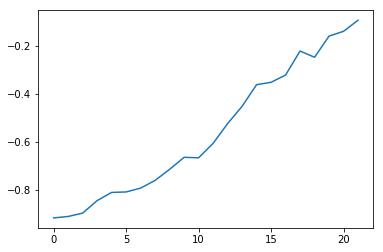

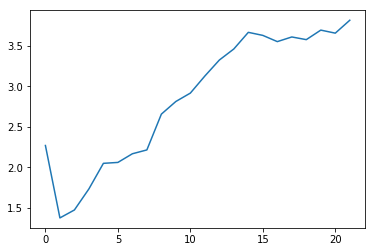

In [14]:
plt.plot(np.array(reward_avg.avgs))
plt.show()
plt.plot(np.array(value_avg.avgs))
plt.show()